- https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB
-  

In [1]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split,StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics.cluster import pair_confusion_matrix
from sklearn.preprocessing import normalize
from memory_profiler import memory_usage

import pandas as pd
import numpy as np

import sklearn as sk

ImportError: cannot import name 'coroutine' from 'asyncio' (c:\Users\Daito\miniconda3\envs\ML\Lib\asyncio\__init__.py)

In [ ]:
class DatasetLoader():
    def __init__(self):
        self.df=None
        self.X = None
        self.y = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.numbers_of_classes = None
        self.classes=None

    def read_dataset(self,file_path,separator=',',class_path=None):
        df = pd.read_csv(file_path, sep=separator)
        self.X = df.copy()
        if class_path!=None:
            df['class'] = pd.read_csv(class_path)
            self.y = df['class']
            self.classes=df['class'].unique()
            self.numbers_of_classes = len(self.classes)
        self.df=df


    def normalize(self,features_to_normalize=None): #features_to_normalize is a list of index
        if features_to_normalize!=None:
            return normalize(self.X[:,features_to_normalize[0]:features_to_normalize[1]])

    def select_features(self,features): #features is a list of features [feature1,feature2,...] or [:156]
        self.X=self.df.iloc[features]
    
    def select_classes(self,classes): #classes is a list of classes [class1,class2,...] with len(classes) = len of dataset
        self.y = classes
        self.classes=np.unique(classes)
        self.numbers_of_classes = len(self.classes)
        
    def split_dataset(self,test_size=0.2): #slit dataset into train and test
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=test_size)
    
    def split_dataset_class(self,class_to_group): #split dataset into train and test based on class
        # Initialize empty lists to store merged sets
        X_train_merged, X_test_merged, y_train_merged, y_test_merged = [], [], [], []
        for i in class_to_group.values():
            df_temp=self.df[self.df['class'].isin(i)]
            X_train, X_test, y_train, y_test = train_test_split(df_temp.iloc[:,:-1], df_temp['class'], test_size=0.2)
            X_train_merged.append(X_train)
            X_test_merged.append(X_test)
            y_train_merged.append(y_train)
            y_test_merged.append(y_test)

        # Merge sets
        return X_train_merged, X_test_merged, y_train_merged, y_test_merged
    
    def split_dataset_data(self,n): #split dataset by data size
        X_train_merged,X_test_merged,y_train_merged,y_test_merged=[],[],[],[]
        df_copy=self.df.copy()
        df_copy.pop('class')
        skf=StratifiedKFold(n_splits=n,shuffle=False)
        skf.get_n_splits(self.X_train,self.y_train)
        for i,(train_index, test_index) in enumerate(skf.split(self.X, self.y)):
            X_train_fold=df_copy.iloc[train_index]
            Y_train_fold=self.y[train_index]
            X_train_merged.append(X_train_fold)
            y_train_merged.append(Y_train_fold)

            X_test_fold=df_copy.iloc[test_index]
            Y_test_fold=self.y[test_index]
            X_test_merged.append(X_test_fold)
            y_test_merged.append(Y_test_fold)
        
        return X_train_merged,y_train_merged,X_test_merged,y_test_merged



In [ ]:
class ModelLoader():
    def __init__(self):
        self.model=None
        self.initial_model=None
        self.optimizer_model=None
        self.optimal_params=None

    def set_optimal_params(self,optimal_params):
        self.optimal_params=optimal_params

    def set_model(self,model):
        self.model=model
        self.initial_model=model

    def reset_model(self):
        self.model=self.initial_model

    def optimize(self,X_train,y_train,cv=5,scoring='accuracy',n_iter=10):
        self.optimizer_model = RandomizedSearchCV(self.model,self.optimal_params,cv=cv,scoring=scoring,n_iter=n_iter)
        self.optimizer_model.fit(X_train,y_train)
        self.optimal_params = self.optimizer_model.best_params_

    def fit_train(self,X_train,y_train):
        self.model.fit(X_train,y_train)

    def partial_fit_train(self,X_train,y_train,classes): # IF model compatible with partial_fit
        mem, res = memory_usage(( self.model.partial_fit, (X_train,y_train,classes), {}), retval=True)
        
    def predict(self,X_test):
        return self.model.predict(X_test)
    
    def score(self,X_test,y_test):
        return self.model.score(X_test,y_test)

In [ ]:
#Get data 
loader = DatasetLoader()
loader.read_dataset('partial_database.csv',class_path='labelsDefault.txt',separator=',')
loader.split_dataset()

#Normalize data, if not already normalized
print(np.shape(loader.X_train),np.shape(loader.X_test),np.shape(loader.y_train),np.shape(loader.y_test))

(4048, 17) (1012, 17) (4048,) (1012,)


In [ ]:
#Get model
model = ModelLoader()
model.set_model(MultinomialNB())

#Optimization 
param = {'alpha': np.linspace(0.5, 1.5, 6),
              'fit_prior': [True, False]}
model.set_optimal_params(param)

model.optimize(loader.X_train,loader.y_train,cv=5,scoring='accuracy',n_iter=10)

#Train model with optimal params
model.set_model(MultinomialNB(**model.optimal_params))


Score accuracy group:  0.8105590062111802
Score accuracy global:  0.2628458498023715
Score accuracy group:  0.9565217391304348
Score accuracy global:  0.33695652173913043
Score accuracy group:  0.5869565217391305
Score accuracy global:  0.4258893280632411
Score accuracy group:  0.5362318840579711
Score accuracy global:  0.4762845849802372
Score accuracy group:  0.5760869565217391
Score accuracy global:  0.508893280632411
Score accuracy group:  0.7391304347826086
Score accuracy global:  0.5424901185770751
Score accuracy group:  0.26811594202898553
Score accuracy global:  0.5632411067193676


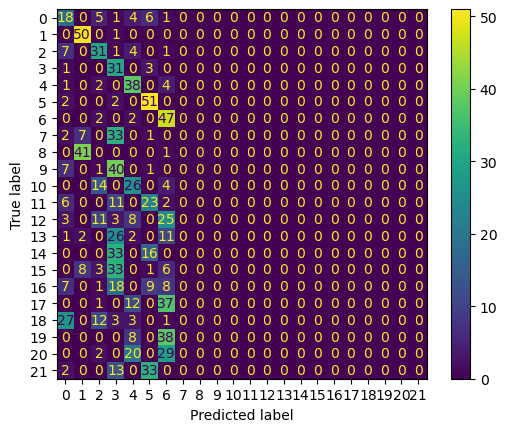

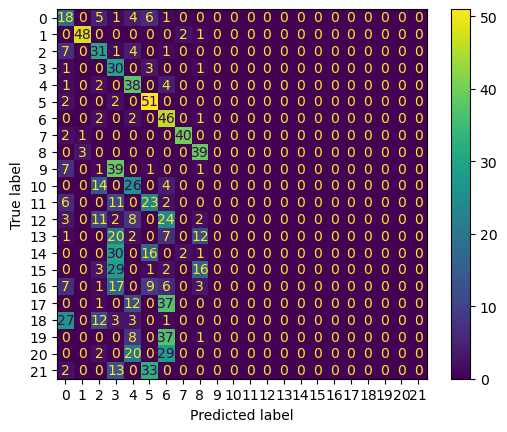

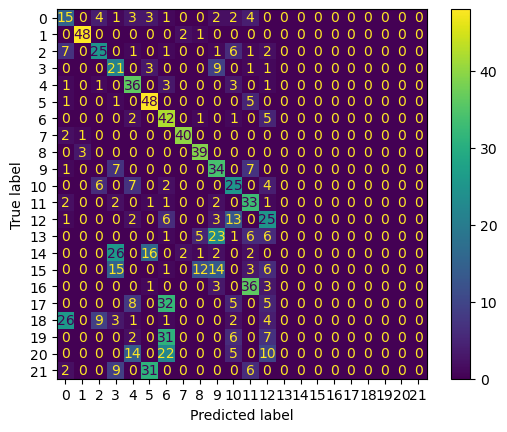

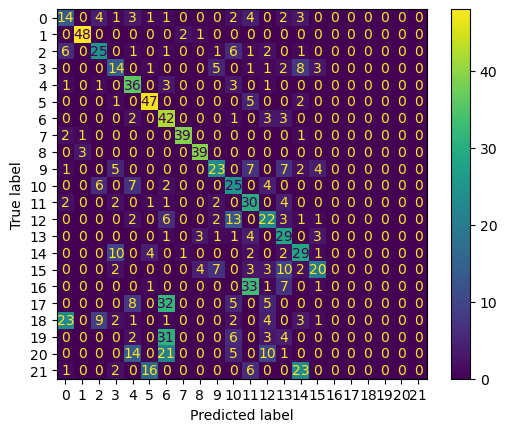

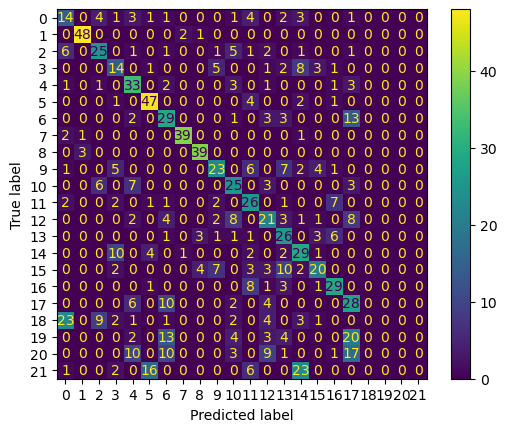

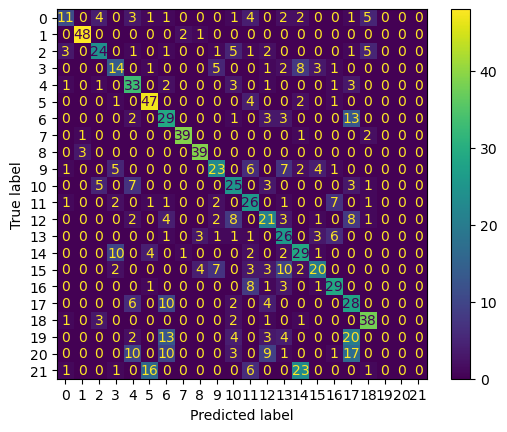

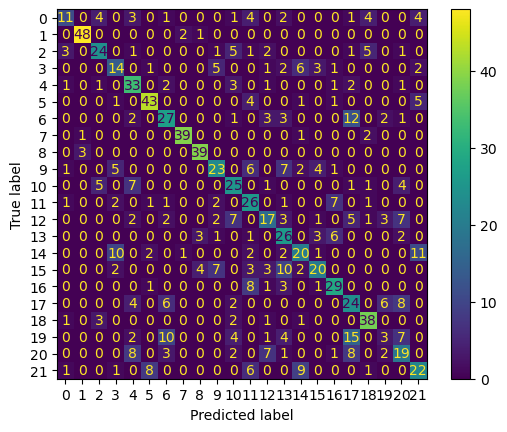

In [ ]:
##Split by class, to increment by class:
class_to_group = {1:[1,2,3,4,5,6,7],2:[8,9],3:[10,11,12,13],4:[14,15,16],5:[17,18],6:[19],7:[20,21,22]}
X_train_merged, X_test_merged, y_train_merged, y_test_merged=loader.split_dataset_class(class_to_group)

#Train model
for X_train,y_train,X_test,y_test in (zip(X_train_merged,y_train_merged,X_test_merged,y_test_merged)):
    model.partial_fit_train(X_train,y_train,classes=loader.classes)
    print("Score accuracy group: ",model.score(X_test,y_test))
    print("Score accuracy global: ",model.score(loader.X_test,loader.y_test))
    
    y_pred=model.predict(loader.X_test)
    cm = confusion_matrix(loader.y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()

model.reset_model()

Score accuracy batch:  0.6067193675889329
Score accuracy global:  0.5533596837944664
Score accuracy batch:  0.66600790513834
Score accuracy global:  0.5602766798418972
Score accuracy batch:  0.6264822134387352
Score accuracy global:  0.5533596837944664
Score accuracy batch:  0.567193675889328
Score accuracy global:  0.5563241106719368
Score accuracy batch:  0.5592885375494071
Score accuracy global:  0.558300395256917
Score accuracy batch:  0.5059288537549407
Score accuracy global:  0.5573122529644269
Score accuracy batch:  0.5138339920948617
Score accuracy global:  0.558300395256917
Score accuracy batch:  0.45652173913043476
Score accuracy global:  0.558300395256917
Score accuracy batch:  0.466403162055336
Score accuracy global:  0.5553359683794467
Score accuracy batch:  0.5
Score accuracy global:  0.5563241106719368


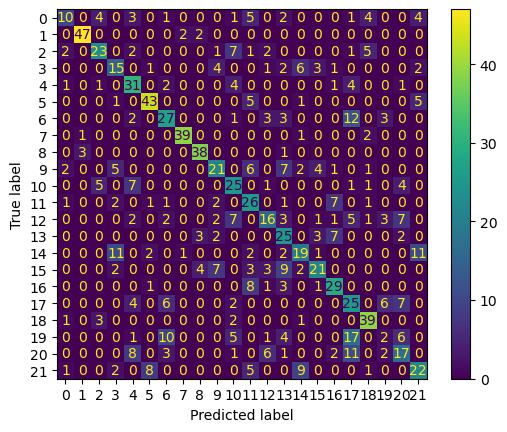

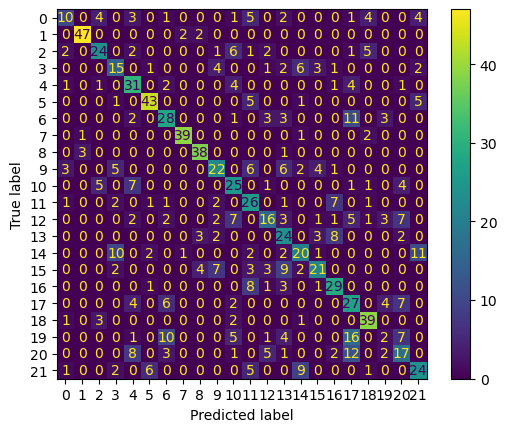

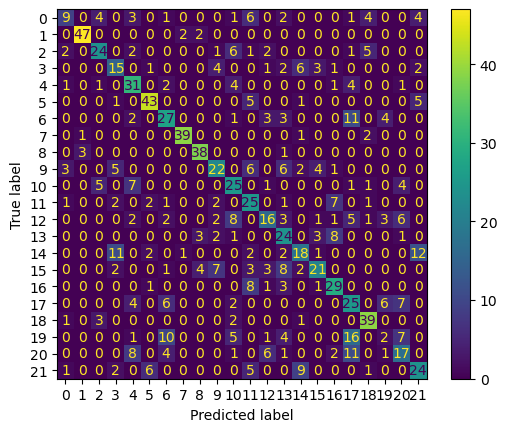

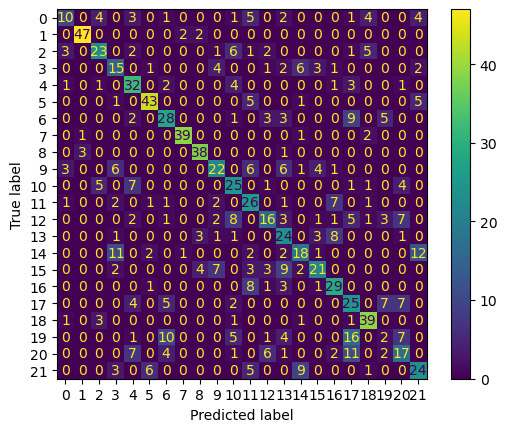

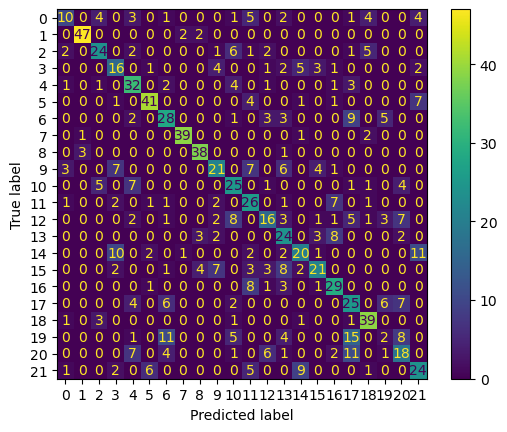

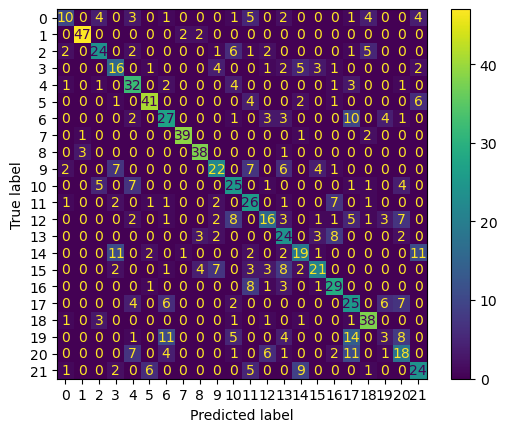

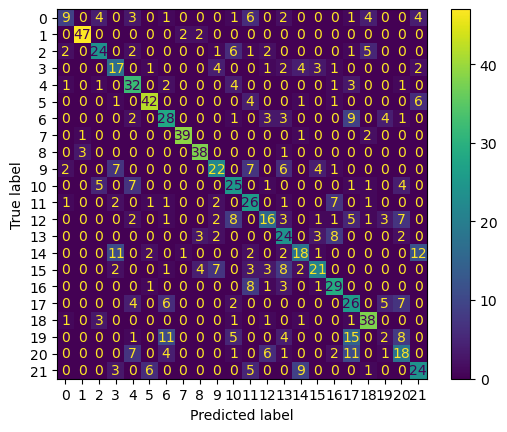

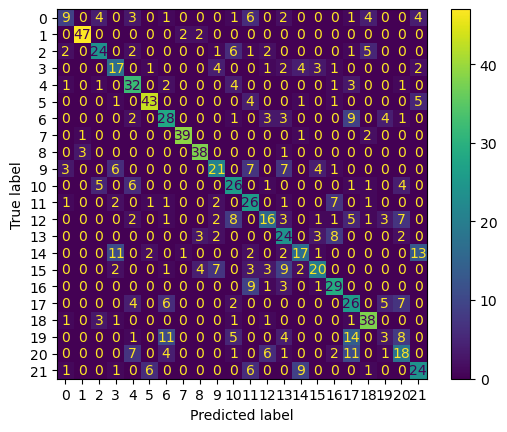

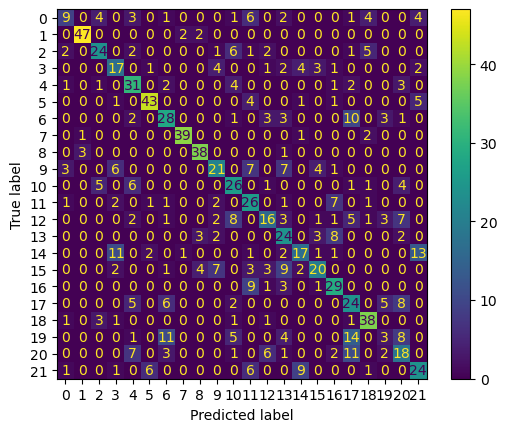

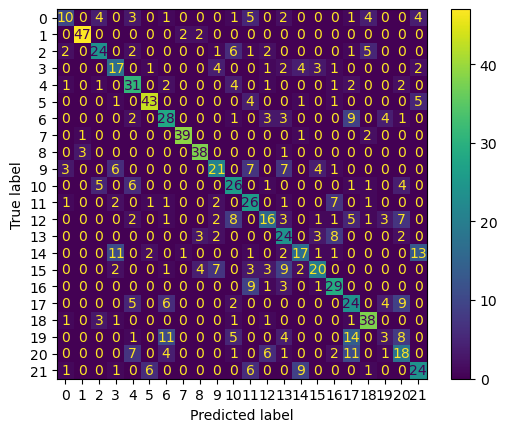

In [ ]:
X_train_split_data,y_train_split_data,X_test_split_data,y_test_split_data=loader.split_dataset_data(10)
for x in range(len(X_train_split_data)):
    model.partial_fit_train(X_train_split_data[x],y_train_split_data[x],classes=loader.classes)
    print("Score accuracy batch: ",model.score(X_test_split_data[x],y_test_split_data[x]))
    print("Score accuracy global: ",model.score(loader.X_test,loader.y_test))
    
    y_pred=model.predict(loader.X_test)
    cm = confusion_matrix(loader.y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()

model.reset_model()